# Load libs

In [1]:
import pandas as pd
import numpy as np

from typing import List, Set

from matplotlib import pyplot as plt
import itertools

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans

from data_cleaning import DataCleaner
from plotly_utils import build_2d_figure, build_3d_figure
from feature_extraction import Doc2VecVectorizer

# Load dataset

In [2]:
df = pd.read_csv("dataset_huge.csv", usecols=["id", "title", "search_query", "description"]).dropna()

# Data analysis
## Query distribution

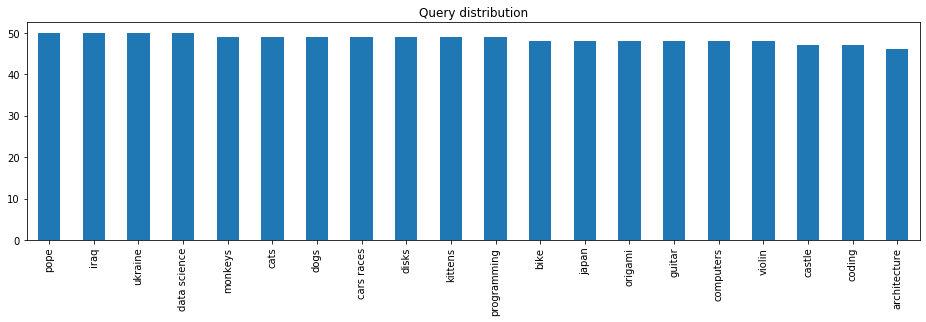

In [3]:
df["search_query"].value_counts().plot(kind="bar", title='Query distribution', figsize=(16, 4))

## Words number in description distribution

Text(0, 0.5, 'Descriptions number with words amount')

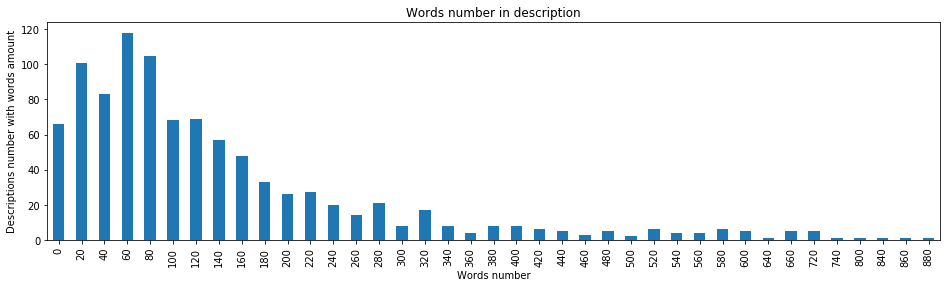

In [4]:
df["description"].apply(
    lambda words: int(len(words.split()) / 20) * 20
).value_counts().sort_index().plot(kind="bar", figsize=(16, 4))

plt.title('Words number in description')
plt.xlabel('Words number')
plt.ylabel('Descriptions number with words amount')

## Dictionary analysis
### Raw dictionary

In [5]:
def build_dictionary(data: pd.Series) -> Set[str]:
    return np.unique(pd.Series(itertools.chain.from_iterable(data.str.split())))

In [6]:
print("Raw dictionary size: {} unique words.".format(len(build_dictionary(df["description"]))))

Raw dictionary size: 32603 unique words.


### Cleaning descriptions

In [7]:
cleaner = DataCleaner()
df["cleaned_description"] = df["description"].apply(cleaner.clean_description)

[nltk_data] Downloading package wordnet to /home/fisz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
print("Cleaned dictionary size: {} unique words.".format(len(build_dictionary(df["cleaned_description"]))))

Cleaned dictionary size: 16269 unique words.


# Embedding
## BOW

In [23]:
# vectorizer = HashingVectorizer(ngram_range=(1, 1), n_features=1000)
# vectorizer = CountVectorizer(ngram_range=(1, 3))
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
# vectorizer = Doc2VecVectorizer(vector_size=100)

dimension_reductor = TruncatedSVD(n_components=3) 
# dimension_reductor = PCA(n_components=3)
# dimension_reductor = KernelPCA(n_components=3)

descriptions = df["cleaned_description"]

embeddings = vectorizer.fit_transform(descriptions)

# normalization over columns (subtract min and divide by peak-to-peak method - guarantee [0, 1] values)
embeddings = (embeddings - embeddings.min(axis=0)) / embeddings.ptp(axis=0)

# normaliztion assertion
assert embeddings.min() == 0.0
assert embeddings.max() == 1.0

truncated_embeddings = dimension_reductor.fit_transform(embeddings)

# truncated_embeddings = (
#     (truncated_embeddings - truncated_embeddings.min(axis=0)) / truncated_embeddings.ptp(axis=0)
# )

print(truncated_embeddings.min())
print(truncated_embeddings.max())

encoded_labels = LabelEncoder().fit_transform(df["search_query"])

(971, 174024)


ValueError: inconsistent shapes

In [ ]:
predicted_classes = KMeans(n_clusters=20).fit_predict(embeddings)

In [21]:
fig = build_2d_figure(df, predicted_classes, truncated_embeddings)
fig.show()